# 本文档提取主城区小区aoi及房价数据
- 数据准备
    - 上海主城区行政区划数据(面)
    - 上海全城房价数据(点)
    - 上海全城小区数据(面)
    
- 基本思路
    - 利用主城区行政区划裁剪房价与小区,获得主城区数据,共12636个小区面要素
    - 第一,通过小区名称与房价数据的小区名称匹配,匹配成功4393个
        - 小区名字相同造成的匹配错误有5个,利用第二步进行修正
    - 第二,将距离某个小区面要素最近的房价点数据连接到该点,以最近的房价作为该点的房价数据
        - 其中,2475个小区包含房价点数据,可能是由于名称不统一,但位置一样造成第一步没匹配上
        - 所有的小区在3千米左右的范围内均有匹配上的房价点
    - 第三,检查匹配后的数据(手动,excel)
        - 修正重名但是不是一个地方的小区
        - 修正距离过远的小区
    - 最后,连接修正后的属性表

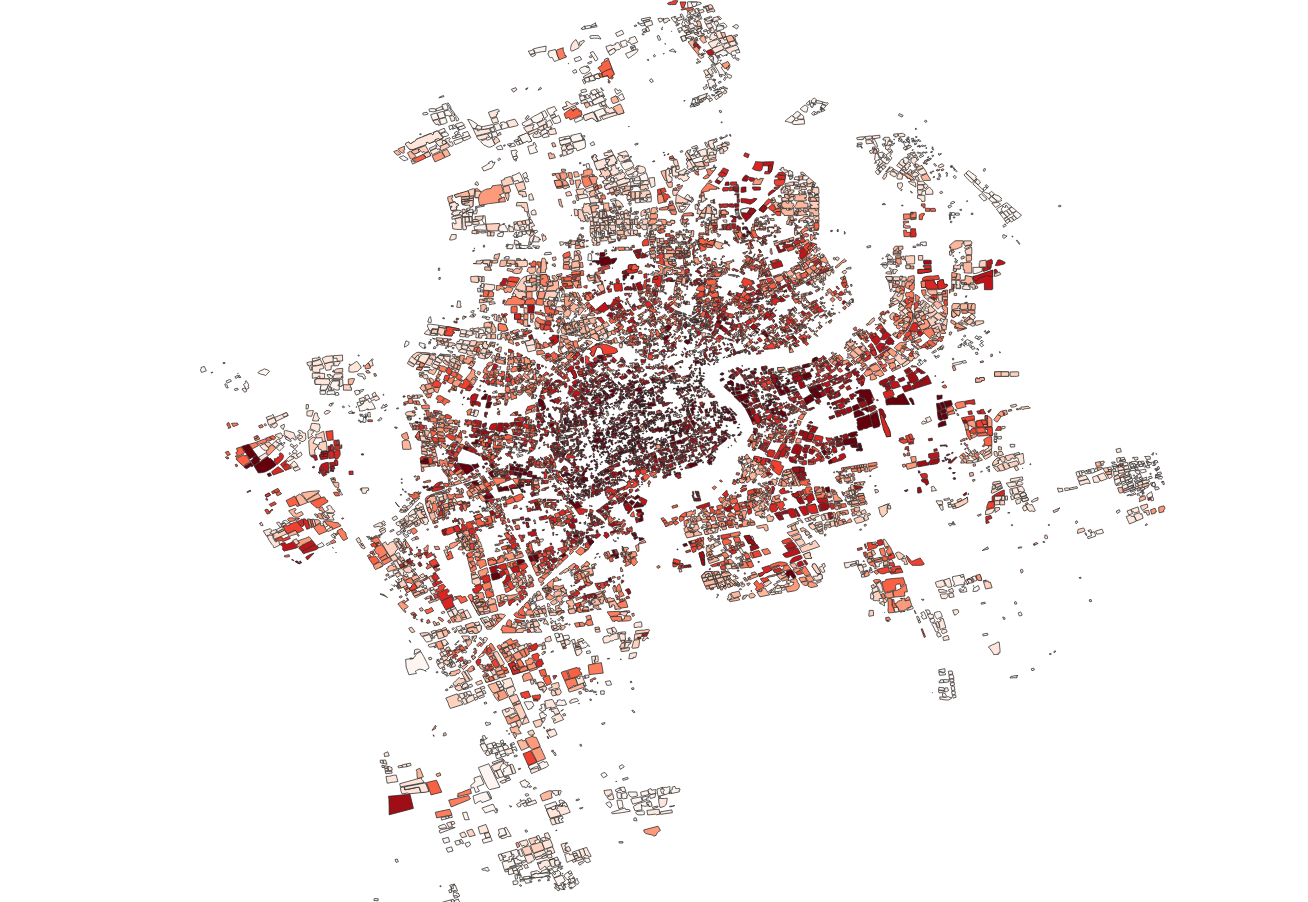

In [1]:
# 初始化依赖包与qgis
import os
import numpy as np
import pandas as pd


import geopandas as gpd
import matplotlib.pyplot as plt

# import pyqgis
from qgis.core import *

# Supply path to qgis install location
QgsApplication.setPrefixPath('/Applications/QGIS-LTR.app/Contents/MacOS', True)

# Create a reference to the QgsApplication.  Setting the
# second argument to False disables the GUI.
qgs = QgsApplication([], False)

# Load providers
qgs.initQgis()

# Write your code here to load some layers, use processing
# algorithms, etc.

# Finally, exitQgis() is called to remove the
# provider and layer registries from memory


from qgis.analysis import QgsNativeAlgorithms
import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
qgs.exitQgis()


# 获取属性表的函数
def getAttributeTable(vlayer):
    """ get attribute table of a vector layer.
    
    Args:
        vlayer : (QgsVectorLayer instance). vector layer

    returns:
         pandas DataFrame: attribute table
    """
    attribute_dict={}
    
    for field in vlayer.fields(): # 初始化各要素属性为空列表
        attribute_dict[field.name()] = []
        
    for feature in vlayer.getFeatures(): # 遍历矢量图层中个要素
        for field in vlayer.fields(): # 遍历各属性字段
            attribute_dict[field.name()].append(feature[field.name()]) # 添加属性字段值进入字典
            
            
    return pd.DataFrame(attribute_dict) #返回DataFrame

Logged warning: Duplicate provider native registered


# 1 主城区数据裁切
## 1.1 导入矢量数据

In [3]:
input_path = '/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/input_data'
sh_main_town_filepath = r'{}/市中心-面/center_city1.shp'.format(input_path)
sh_house_price_filepath = r'{}/shanghai_house_price.shp'.format(input_path)
sh_aoi_price_filepath = r'{}/上海市小区和写字楼/上海市AOI数据.shp'.format(input_path)


sh_main_town = QgsVectorLayer(sh_main_town_filepath, "Shanghai main town", "ogr")
sh_house_price = QgsVectorLayer(sh_house_price_filepath, "Shanghai house price", "ogr")
sh_aoi_layer = QgsVectorLayer(sh_aoi_price_filepath, "Shanghai aoi", "ogr")


## 1.2 裁切矢量数据

In [10]:
temp_path = '/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/temp'

# 裁切房价点
clip_params = {"INPUT":sh_house_price,"OVERLAY":sh_main_town,"OUTPUT":r'{}/sh_main_house_price.shp'.format(temp_path)}
#processing.run('qgis:clip',clip_params)

# 裁切小区
clip_params = {"INPUT":sh_aoi_layer,"OVERLAY":sh_main_town,"OUTPUT":r'{}/sh_main_aoi.shp'.format(temp_path)}
#processing.run('qgis:clip',clip_params)

Warning 1: Value '(浦东高东)光明路41弄, 光明路61弄, 光明路62弄, 光明路81弄, 光明路111弄, 光明路132弄, 光明路141弄, 光明路161弄, 光明路181弄, 光明路182弄, 光明路221弄, 光明路222弄, 光明路42弄, 光明路162弄, 光明�' of field address has been truncated to 254 characters.  This warning will not be emitted any more for that layer.


{'OUTPUT': '/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/temp/sh_main_house_price.shp'}

# 2 按属性连接

In [13]:
sh_main_house_price_filepath = r'{}/sh_main/sh_main_house_price.shp'.format(input_path)
sh_main_aoi_price_filepath = r'{}/sh_main/sh_main_aoi.shp'.format(input_path)
sh_main_town_filepath = r'{}/sh_main/sh_main_town.shp'.format(input_path)

sh_main_town = QgsVectorLayer(sh_main_town_filepath, "Shanghai main town", "ogr")
sh_main_house_price = QgsVectorLayer(sh_main_house_price_filepath, "Shanghai house price", "ogr")
sh_main_aoi = QgsVectorLayer(sh_main_aoi_price_filepath, "Shanghai aoi", "ogr")

sh_main_town_attr = getAttributeTable(sh_main_town)

sh_main_house_price_attr = getAttributeTable(sh_main_house_price)

sh_main_aoi_attr = getAttributeTable(sh_main_aoi)

In [15]:
sh_main_house_price_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9510 entries, 0 to 9509
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       9510 non-null   object 
 1   price      9510 non-null   int64  
 2   county     9510 non-null   object 
 3   town       9510 non-null   object 
 4   address    9510 non-null   object 
 5   lng_wgs84  9510 non-null   float64
 6   lat_wgs84  9510 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 520.2+ KB


In [16]:
sh_main_aoi_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12636 entries, 0 to 12635
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        12636 non-null  object
 1   province    12636 non-null  object
 2   city        12636 non-null  object
 3   area        12636 non-null  object
 4   address     12636 non-null  object
 5   uid         12636 non-null  object
 6   detail_url  12636 non-null  object
 7   tag         12636 non-null  object
 8   wgs84_lng   12636 non-null  object
 9   wgs84_lat   12636 non-null  object
 10  行业大�        12636 non-null  object
 11  行业子�        12636 non-null  object
 12  Get_time    12636 non-null  object
dtypes: object(13)
memory usage: 1.3+ MB


In [18]:
sh_main_house_price_attr

,name,price,county,town,address,lng_wgs84,lat_wgs84
0,中海万锦城(四期),6885,闸北,不夜城,(闸北不夜城)永兴路928弄,121.455056,31.252708
1,美隆大厦,8406,宝山,大华,(宝山大华)大华三路81号,121.414087,31.278280
2,爱久家园,10987,杨浦,中原,(杨浦中原)国伟路300号,121.528517,31.333909
3,亚新生活广场,11440,普陀,长寿路,(普陀长寿路)长寿路401、401甲号,121.432953,31.240889
4,香樟小筑,12276,闵行,老闵行,(闵行老闵行)江川路633弄,121.399647,31.002328
...,...,...,...,...,...,...,...
9505,中邦晶座,98291,浦东,联洋,(浦东联洋)丁香路1066弄,121.551680,31.229577
9506,霍山路66弄,98507,虹口,北外滩,(虹口北外滩)霍山路66弄,121.505928,31.255162
9507,东方丰甸苑(别墅),98582,浦东,南码头,(浦东南码头)东方路2995弄,121.515086,31.195889
9508,东昌新村,99917,浦东,陆家嘴,"(浦东陆家嘴)东昌新村, 东宁路348号, 东宁路350号, 东宁路360号",121.507249,31.234651


In [20]:
sh_main_aoi_attr.head(1)

,name,province,city,area,address,uid,detail_url,tag,wgs84_lng,wgs84_lat,行业大�,行业子�,Get_time
0,盛世年华小区,上海市,上海市,浦东新区,上海市浦东新区洋泾街道,1e0f0deb63876ada1d1d1148,"https://map.baidu.com/poi/怡家园/@13530401.154588437,3640824.8874104554,18.43z?uid=1e0f0deb63876ada1d1d1148&info_merge=1&isBizPoi=false&ugc_type=3&ugc_ver=1&device_ratio=2&compat=1&pcevaname=pc4.1&querytype=detailConInfo&da_src=shareurl",房地产;住宅区,NULL,NULL,房地产,住宅区,2021-10-25 09:56:15


In [27]:
# join by field value
jv_params = {"INPUT":sh_main_aoi,'FIELD':'name', 
             "INPUT_2":sh_main_house_price,'FIELD_2':'name', 
             'PREFIX':'jnhp', 'DISCARD_NONMATCHING':False, 
             'OUTPUT':r'{}/sh_main_aoi_jv.shp'.format(temp_path)}
#processing.run('native:joinattributestable', jv_params)

{'JOINED_COUNT': 4393,
 'OUTPUT': '/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/temp/sh_main_aoi_jv.shp',
 'UNJOINABLE_COUNT': 8243}

# 3. 按距离,连接最近的房价点

In [28]:
sh_main_aoi_jv = QgsVectorLayer(r'/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/temp/sh_main_aoi_jv.shp',
                                           'sh main aoi temp', 'ogr')

In [30]:
# Join nearest

nn_params = {"INPUT":sh_main_aoi_jv,
             "INPUT_2":sh_main_house_price,
             'PREFIX':'nnhp', 
             'MAX_DISTANCE':5000,
             'OUTPUT':r'{}/sh_main_aoi_nn.shp'.format(temp_path)}
#processing.run('native:joinbynearest', nn_params)

{'JOINED_COUNT': 12636,
 'OUTPUT': '/Users/oo/Desktop/5.Learning/esri-ces-contest/Codes/temp/sh_main_aoi_nn.shp',
 'UNJOINABLE_COUNT': 0}

# 4.保存为csv在excel中进一步处理

In [31]:
sh_main_aoi_nn = QgsVectorLayer(r'{}/sh_main_aoi_nn.shp'.format(temp_path),'sh main aoi temp', 'ogr')
#getAttributeTable(sh_main_aoi_nn).to_csv('aoi.csv', encoding='utf_8_sig')